In [1]:
import warnings
from pathlib import Path

import numpy as np
from sklearn.model_selection import KFold

from gfos.data.utils import load_layout
from gfos.data.dataset import sample_configs
from gfos.utils.misc import seed_everything

SEED = 42
LAYOUT_DIR = r"H:\data\gfos\predict-ai-model-runtime\npz_all\npz\layout"
SOURCE = "nlp"
SEARCH = "random"
MAX_CONFIGS = 10240
NUM_FOLDS = 5
OUTPUT_ROOT = "../../data/indices"


data_root = Path(OUTPUT_ROOT)
data_root.mkdir(exist_ok=True)

seed_everything(SEED)
warnings.filterwarnings("ignore")

In [2]:
files = load_layout(LAYOUT_DIR, model_type=SOURCE, compile_type=SEARCH)
train_val_file = files["train"] + files["valid"]
cs = [len(np.load(file)["config_runtime"]) for file in train_val_file]

print(f"Fewest configs: {min(cs)}")
print(f"Most configs: {max(cs)}")

Fewest configs: 10750
Most configs: 100040


Use original split

In [3]:
folds = [(files["train"], files["valid"])] * NUM_FOLDS

Split training and valid (No use)

In [4]:
# folds = []
# for train_idx, valid_idx in KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED).split(train_val_file):
#     folds.append(
#         (
#             [train_val_file[idx] for idx in train_idx],
#             [train_val_file[idx] for idx in valid_idx],
#         )
#     )
# print("File in each fold:")

# for train_files, val_files in folds:
#     print(f"Train: {len(train_files)}, Val: {len(val_files)}")

Sample indices in training files

In [5]:
for fold, (train_files, valid_files) in enumerate(folds):
    fold_dir = data_root / f"{SOURCE}_{SEARCH}" / f"{fold}"
    train_dir = fold_dir / "train"
    train_dir.mkdir(exist_ok=True, parents=True)
    valid_dir = fold_dir / "valid"
    valid_dir.mkdir(exist_ok=True, parents=True)

    for file in train_files:
        model_id = Path(file).stem
        npz = np.load(file)
        config_runtime = npz["config_runtime"]
        
        c = len(config_runtime)
        mc = min(MAX_CONFIGS, c) if MAX_CONFIGS > 0 else c
        third = MAX_CONFIGS // 3

        sorted_indices = np.argsort(config_runtime)
        
        if third * NUM_FOLDS > c or 2 * (third * NUM_FOLDS) > c:
            third = mc // 3
            keep_indices = np.concatenate(
                [
                    sorted_indices[:third],  # Good configs.
                    sorted_indices[-third:],  # Bad configs.
                    np.random.choice(
                        sorted_indices[third:-third],
                        mc - 2 * third,
                    ),
                ]
            )
        else:
            keep_indices = np.concatenate(
                [
                    np.random.choice(
                        sorted_indices[:third * NUM_FOLDS],
                        third,
                    ), # Good configs.
                    np.random.choice(
                        sorted_indices[-third * NUM_FOLDS:],
                        third,
                    ), # Bad configs.
                    np.random.choice(
                        sorted_indices[third * NUM_FOLDS: -third * NUM_FOLDS],
                        mc - 2 * third,
                    ),
                ]
            )

        np.save(train_dir / f"{model_id}.npy", keep_indices)

    for file in valid_files:
        keep_indices = np.arange(len(np.load(file)["config_runtime"]))
        np.save(valid_dir / f"{Path(file).stem}.npy", keep_indices)


talking-heads_large_batch_size_32_train has 11098 configs.
albert_en_base_batch_size_16_test has 100040 configs.


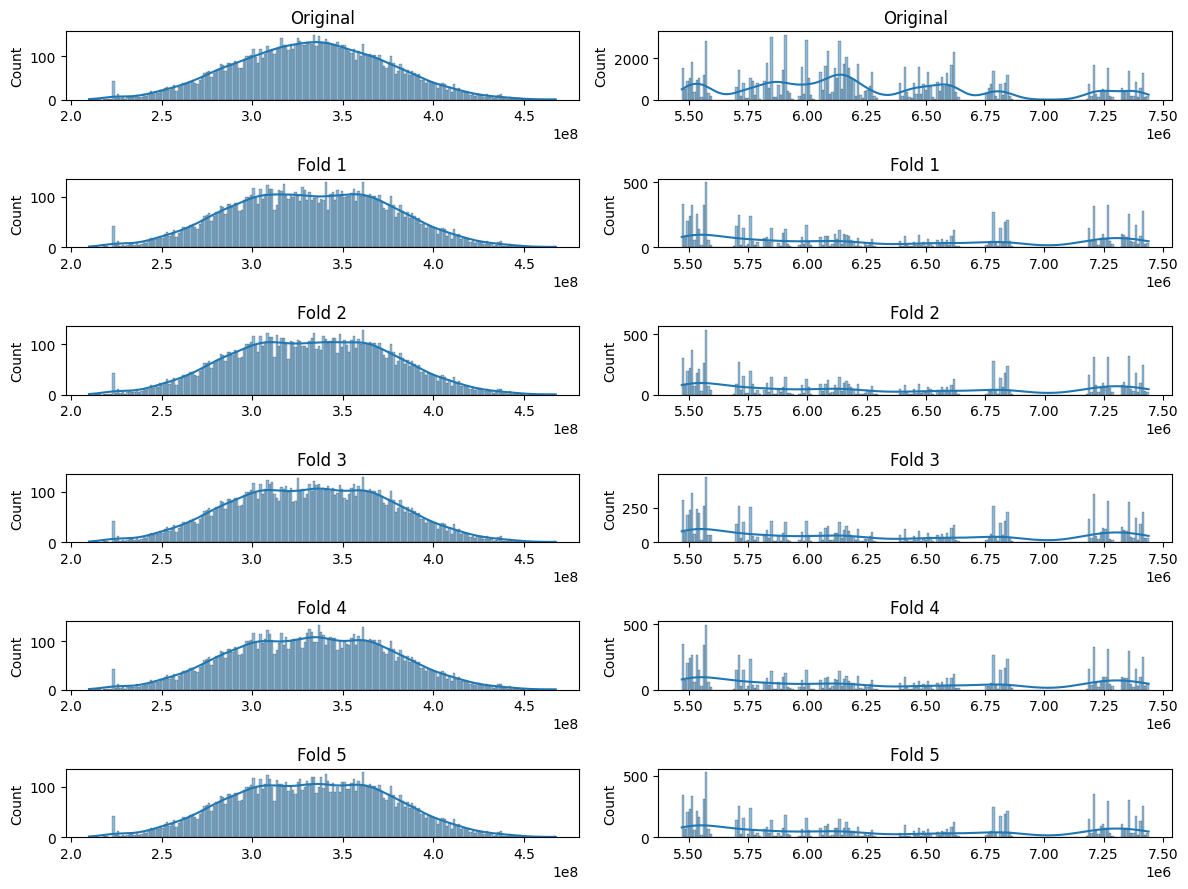

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


# Original hist
train_files = files["train"]
cs = [len(np.load(file)["config_runtime"]) for file in train_files]

axes = plt.subplots(NUM_FOLDS + 1, 2, figsize=(12, 9))[1].flatten()

fewest_configs_idx = np.argmin(cs)
model = Path(train_files[fewest_configs_idx]).stem
print(f"{model} has {cs[fewest_configs_idx]} configs.")
indices_folds = [np.load(data_root / f"{SOURCE}_{SEARCH}" / f"{i}" / "train" /  f"{model}.npy") for i in range(NUM_FOLDS)]
runtime = np.load(train_files[fewest_configs_idx])["config_runtime"]
sns.histplot(runtime, kde=True, bins=200, ax=axes[0])
axes[0].set_title("Original")
for i in range(NUM_FOLDS):
    runtime_fold = runtime[indices_folds[i]]
    sns.histplot(runtime_fold, kde=True, ax=axes[2*(i+1)], bins=200)
    axes[2*(i+1)].set_title(f"Fold {i+1}")


most_configs_idx = np.argmax(cs)
model = Path(train_files[most_configs_idx]).stem
print(f"{model} has {cs[most_configs_idx]} configs.")
indices_folds = [np.load(data_root / f"{SOURCE}_{SEARCH}" / f"{i}" / "train" / f"{model}.npy") for i in range(NUM_FOLDS)]
runtime = np.load(train_files[most_configs_idx])["config_runtime"]
sns.histplot(runtime, kde=True, bins=200, ax=axes[1])
axes[1].set_title("Original")
for i in range(NUM_FOLDS):
    runtime_fold = runtime[indices_folds[i]]
    sns.histplot(runtime_fold, kde=True, ax=axes[2*i+3], bins=200)
    axes[2*i+3].set_title(f"Fold {i+1}")

plt.tight_layout()